In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

In [42]:
%matplotlib inline
import logging
import numpy as np
import pandas as pd
import quandl
quandl.ApiConfig.api_key = 'VvmHMhvuE13zMSZxgCEC'

import cvxportfolio as cp

Download the problem data from Quandl. We select four liquid stocks, and the risk-free rate.

In [249]:
#tickers = ['SPY', 'TLT', 'VNQ', 'FXY', 'VWO', 'GDX', 'SHV']
#start_date = '2012-01-02'
#end_date = '2016-12-30'
tickers = ['FXCH', 'FXY', 'FXE', 'FXC']
start_date='2016-12-01'
end_date='2019-08-31'
returns = pd.DataFrame(dict([(ticker, quandl.get('EOD/'+ticker, 
                                    start_date=start_date, 
                                    end_date=end_date)['Adj_Close'].pct_change())
                for ticker in tickers]))
returns[["USDOLLAR"]]=quandl.get('FRED/DTB3', start_date=start_date, end_date=end_date)/(250*100)
returns = returns.fillna(method='ffill').iloc[1:]

returns.tail()

,FXCH,FXY,FXE,FXC,USDOLLAR
Date,,,,,
2019-08-26,-0.007106,-0.007525,-0.003966,0.002155,0.000078
2019-08-27,0.000304,0.003679,-0.000569,-0.002957,0.000078
2019-08-28,-0.001591,-0.004221,-0.001233,0.000539,0.000078
2019-08-29,0.003101,-0.003124,-0.001804,-0.000539,0.000078
2019-08-30,0.000000,0.002126,-0.005803,-0.000135,0.000078


In [250]:
r_hat = pd.read_csv('r_hat_fx.csv', parse_dates=['Date']).set_index('Date')[['FXCH', 'FXY', 'FXE', 'FXC']]
r_hat_cash = returns['USDOLLAR'].rolling(window=40, min_periods=40).mean().shift(1).dropna()
r_hat = r_hat.merge(r_hat_cash, how='inner', left_index=True, right_index=True)
r_hat.head()

,FXCH,FXY,FXE,FXC,USDOLLAR
Date,,,,,
2017-02-22,0.001243,-0.000217,0.000004,-0.000193,0.000021
2017-02-23,0.000700,-0.000224,-0.000012,-0.000175,0.000021
2017-02-24,0.000626,-0.000231,-0.000029,-0.000159,0.000021
2017-02-27,0.000569,-0.000236,-0.000047,-0.000144,0.000021
2017-02-28,0.000517,-0.000241,-0.000064,-0.000131,0.000021


We use LSTM predictions for returns but with rolling volatility estimates that are equal to historical averages

In [251]:
Sigma_hat = returns.rolling(window=40, min_periods=40, closed='neither').cov().dropna()

print('r_hat first line')
print(r_hat.iloc[0])
print('r_hat length: ' + str(len(r_hat)))
print('Sigma_hat first line')
print(Sigma_hat.iloc[0])
print('Sigma_hat length: ' + str(len(Sigma_hat)))

r_hat first line
FXCH        0.001243
FXY        -0.000217
FXE         0.000004
FXC        -0.000193
USDOLLAR    0.000021
Name: 2017-02-22 00:00:00, dtype: float64
r_hat length: 636
Sigma_hat first line
FXCH        4.813772e-05
FXY         1.862544e-05
FXE         1.333800e-05
FXC         7.910425e-06
USDOLLAR   -1.306086e-09
Name: (2017-01-31 00:00:00, FXCH), dtype: float64
Sigma_hat length: 3255


Here we define the transaction cost and holding cost model (sections 2.3 and 2.4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). The data can be expressed 
as 
- a scalar (like we're doing here), the same value for all assets and all time periods;
- a Pandas Series indexed by the asset names, for asset-specific values; 
- a Pandas DataFrame indexed by timestamps with asset names as columns, for values that vary by asset and in time.

In [252]:
tcost_model=cp.TcostModel(half_spread=10E-4)
hcost_model=cp.HcostModel(borrow_costs=1E-4)

/Users/razvan/PyRepo/cvxportfolio/cvxportfolio/utils/data_management.py:26: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if (isinstance(obj, pd.Panel) or


We define the single period optimization policy (section 4 [of the paper](https://web.stanford.edu/~boyd/papers/cvx_portfolio.html)). 

In [262]:
risk_model = cp.FullSigma(Sigma_hat)
gamma_risk, gamma_trade, gamma_hold = 5., 1.5, 1.
leverage_limit = cp.LeverageLimit(2)
min_weight = cp.MinWeights(-0.5)
max_weight = cp.MaxWeights(0.5)

spo_policy = cp.SinglePeriodOpt(return_forecast=r_hat, 
                                costs=[gamma_risk*risk_model, gamma_trade*tcost_model, gamma_hold*hcost_model],
                                constraints=[leverage_limit, min_weight, max_weight])

/Users/razvan/PyRepo/cvxportfolio/cvxportfolio/utils/data_management.py:26: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if (isinstance(obj, pd.Panel) or


We run a backtest, which returns a result object. By calling its summary method we get some basic statistics.

In [263]:
market_sim=cp.MarketSimulator(returns, [tcost_model, hcost_model], cash_key='USDOLLAR') 
init_portfolio = pd.Series(index=returns.columns, data=500000 / (len(returns.columns) - 1))
init_portfolio.USDOLLAR = 0
results = market_sim.run_multiple_backtest(init_portfolio,
                               start_time='2017-03-01',  end_time='2019-08-31',  
                               policies=[spo_policy, cp.Hold()],
                                          loglevel=logging.WARNING, parallel=True)
results[0].summary()

/Users/razvan/PyRepo/cvxportfolio/cvxportfolio/risks.py:46: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(obj, pd.Panel):


Number of periods                               631
Initial timestamp               2017-03-01 00:00:00
Final timestamp                 2019-08-30 00:00:00
Portfolio return (%)                         -0.473
Excess return (%)                            -2.199
Excess risk (%)                               5.188
Sharpe ratio                                 -0.424
Max. drawdown                                11.543
Turnover (%)                                 10.481
Average policy time (sec)                     0.039
Average simulator time (sec)                  0.003


The total value of the portfolio in time.

-7530.246003542561

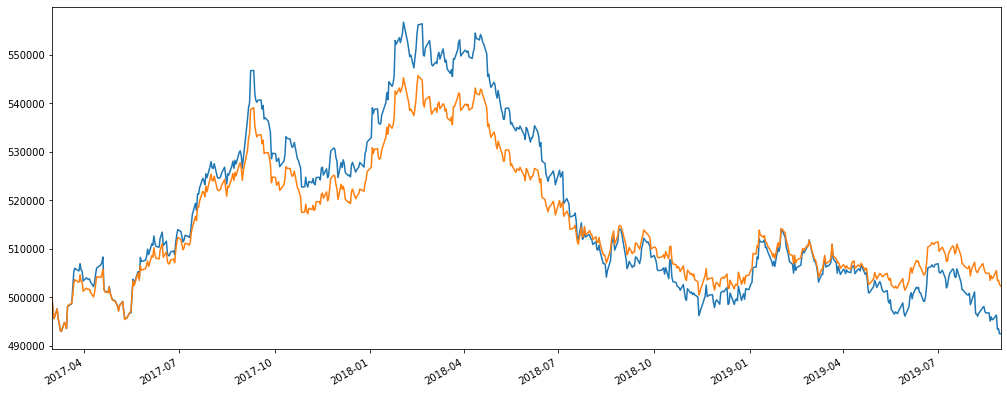

In [264]:
results[0].v.plot(figsize=(17,7))
results[1].v.plot(figsize=(17,7))
results[0].profit

In [265]:
results[0].v

2017-03-01    500000.000000
2017-03-02    497372.694517
2017-03-03    495569.425987
2017-03-06    497599.727829
2017-03-07    495548.151717
                  ...      
2019-08-26    496313.882110
2019-08-27    493389.468799
2019-08-28    493485.730809
2019-08-29    492457.487213
2019-08-30    492469.753996
Length: 631, dtype: float64

The weights vector of the portfolio in time.

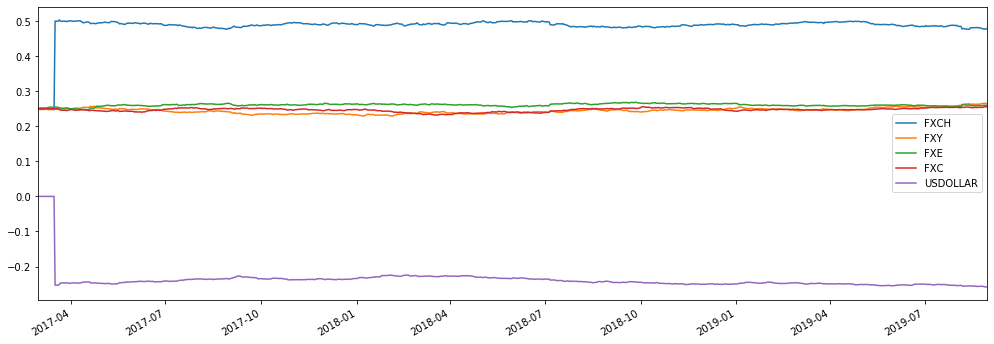

In [266]:
results[0].w.plot(figsize=(17,6))

In [229]:
from datetime import datetime
weights = results[0].w
weights.iloc[1120:]

,index,SPY,EWG,EWH,FXI,EWJ,MDY,USDOLLAR
1120,2019-06-17,-0.468518,-0.424297,-1.791753e-01,0.418023,-0.000173,0.496931,1.157208
1121,2019-06-18,-0.395437,-0.422819,-1.802734e-01,0.502799,-0.000173,0.498767,0.997135
1122,2019-06-19,-0.398158,-0.428982,-1.845154e-01,0.512768,-0.000173,0.503924,0.995136
1123,2019-06-20,-0.365348,-0.429929,-1.868605e-01,0.503489,-0.000174,0.501126,0.977696
1124,2019-06-21,-0.247267,-0.433024,-1.886370e-01,0.507736,-0.000176,0.501658,0.859710
1125,2019-06-24,-0.183910,-0.434369,-1.222734e-01,0.499627,-0.000175,0.498888,0.742213
1126,2019-06-25,-0.178169,-0.435696,-3.343639e-11,0.502062,-0.000175,0.497703,0.614275
1127,2019-06-26,-0.164382,-0.435431,7.027279e-02,0.495100,-0.000176,0.500770,0.533846
1128,2019-06-27,-0.163513,-0.435450,1.731024e-01,0.503805,-0.000175,0.496975,0.425255
1129,2019-06-28,-0.162080,-0.431509,2.310533e-01,0.499352,-0.000173,0.500315,0.363042
